
# Exercice : Contamination dans un lac

Nous allons étendre l'exercice de contamination d'une rivière de 1D à 2D. On suppose la fuite continue (constante dans le temps) d'un contaminant dans un lac qui est animé d'un courant en $x$ et $y$ (Figure ci-dessous). La source de contamination est un périmètre circulaire centré en $x_{src} = L_x/4$ et $y_{src} = L_y/4$ de rayon $r_C = 1.5$ m. Pour cela, vous pouvez utiliser la fonction `np.meshgrid`.

Le polluant se décompose avec une constante de décroissance de $\gamma = 0.001$. Les équations à résoudre sont presque les mêmes que pour l'exercice précédent, à l'exception du terme du taux de dégradation (ou de réaction) :

$$\frac{\partial C}{\partial t} = -\frac{\partial q_x}{\partial x} -\frac{\partial q_y}{\partial y} - V_x \frac{\partial C}{\partial x} - V_y \frac{\partial C}{\partial y}\ -\gamma C,\: $$

$$q_x = - D \frac{\partial C}{\partial x} \: ; \: \: q_y = - D \frac{\partial C}{\partial y}$$

où $C$ est la concentration du contaminant, $D$ est la diffusivité, et $V_x$ et $V_y$ sont les vitesses horizontales de l'eau. Nous supposons que la concentration sur les bords du domaine est nulle en tout temps. 
 
![](./fig/ex_2.png)

*Figure: Let but de l'exercise est de modéliser l'évolution d'un contaminant dans un lac (ici Q=2).*

Nous voulons écrire un code avec deux variantes. Définissez un paramètre Q, qui vaut 1 ou 2, et utilisez des clauses conditionnelles pour écrire un unique code générique qui fonctionne pour les deux variantes.

- Q1: Réalisez une première simulation avec une vitesse uniforme sur tout le domaine.
- Q2: Ensuite, changez le signe de la vitesse `V_x` dans la partie supérieure du modèle ($y > L_y/2$).



| **Paramètres:**                               | **Valeurs:**              |
|-----------------------------------------------|---------------------------|
| Concentration du polluant "Cmax"             | 20                        |
| Longueur $x$ du modèle $L_x$                 | 50 m                      |
| Longueur $y$ du modèle $L_y$                 | 50 m                      |
| Centre de la fuite $x$                       | $L_x/4$ m                 |
| Centre de la fuite $y$                       | $L_y/4$ m                 |
| Rayon de la fuite $r_C$                      | 1.5 m                     |
| Nombre de cellules "nx"                       | 110                       |
| Nombre de cellules "ny"                       | 120                       |
| Temps total                                   | 500 s                     |
| Diffusivité du polluant                       | 0.02 m²/s                 |
| Constante de décroissance $\gamma$           | 0.001  $s^{-1}$      |
| **Q=1**                                       |                           |
| Vitesse x du lac $V_x$                       | 0.1 m/s                   |
| Vitesse y du lac $V_y$                       | 0.2 m/s                   |
| **Q=2**                                      |                           |
| $V_x$ dans la moitié inférieure               | 0.1 m/s                   |
| $V_x$ dans la moitié supérieure               | -0.1 m/s                  |
| Vitesse y du lac $V_y$                       | 0.2 m/s                   |

*Table 1: Paramètres pour le problème du lac.*

### ✅ **À vous de faire !** 

## Imports nécessaires et définition des paramètres globaux

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, clear_output

# ========================================
# PARAMÈTRES GLOBAUX
# ========================================

Q = 1  # Variante du problème (1 ou 2)

# Paramètres physiques
D = 0.02          # Diffusivité (m²/s)
Lx = 50.0         # Longueur x du domaine (m)
Ly = 50.0         # Longueur y du domaine (m)
Vx0 = 0.1         # Vitesse de base en x (m/s)
Vy0 = 0.2         # Vitesse de base en y (m/s)
Cmax = 20.0       # Concentration maximale
gamma = 1e-3      # Constante de décroissance (s⁻¹)
ttot = 500.0      # Temps total de simulation (s)

# Paramètres de la source
xsrc = Lx / 4     # Position x de la source (m)
ysrc = Ly / 4     # Position y de la source (m)
r_c = 1.5         # Rayon de la source (m)

# Paramètres numériques
nx = 110          # Nombre de cellules en x
ny = 120          # Nombre de cellules en y
dx = Lx / (nx - 1)  # Pas d'espace en x
dy = Ly / (ny - 1)  # Pas d'espace en y
nout = 250        # Fréquence d'affichage

# Grilles spatiales
x = np.linspace(0, Lx, nx)
y = np.linspace(0, Ly, ny)
X, Y = np.meshgrid(x, y)


## Étape 1 : Initialisation de la solution

Créons une fonction pour initialiser le champ de concentration.

In [4]:
def initial_solution():
    return np.zeros((ny, nx))

### ✅ Test de la fonction `initial_solution`

In [5]:
C = initial_solution()
print(f"Forme: {C.shape}, somme: {C.sum()} (devrait être 0)")
print(f"✓ Initialisation correcte")

Forme: (120, 110), somme: 0.0 (devrait être 0)
✓ Initialisation correcte


## Étape 2 : Initialisation du courant

Créons une fonction pour initialiser les champs de vitesse.

In [6]:
def initial_current():
    Vx = Vx0 * np.ones((ny, nx - 1))
    Vy = Vy0 * np.ones((ny - 1, nx))
    
    if Q == 2:
        Vx[int(ny / 2):, :] = -Vx0
    
    return Vx, Vy

### ✅ Test de la fonction `initial_current`

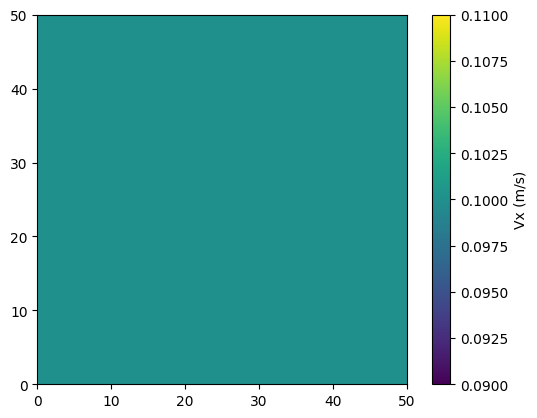

In [7]:
Vx, Vy = initial_current()
plt.imshow(Vx, extent=[0, Ly, 0, Lx], origin='lower')
plt.colorbar(label='Vx (m/s)')
plt.show()

---
## Étape 3 : Mise à jour de la source

Créons une fonction pour appliquer la source de contamination.

In [16]:
def update_source(C):
    rad = np.sqrt((X - xsrc)**2 + (Y - ysrc)**2)
    C[rad < r_c] = Cmax

### ✅ Test de la fonction `update_source`

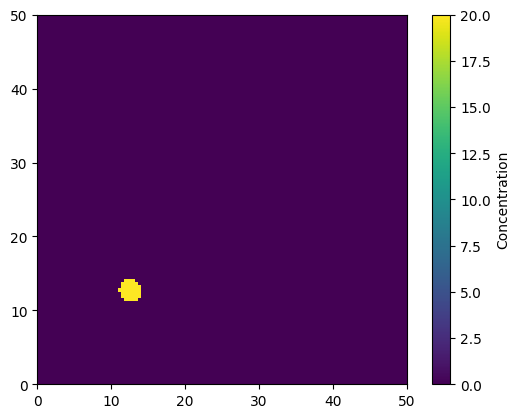

In [17]:
C = initial_solution()
update_source(C)
plt.imshow(C, extent=[0, Ly, 0, Lx], origin='lower')
plt.colorbar(label='Concentration')
plt.show()

## Étape 4 : Diffusion

Créons une fonction pour calculer le terme de diffusion.

In [10]:
def update_diffusion(C, dt):
    qy = -D * (C[1:, 1:-1] - C[:-1, 1:-1]) / dy
    qx = -D * (C[1:-1, 1:] - C[1:-1, :-1]) / dx
    dCdtd = -((qx[:, 1:] - qx[:, :-1]) / dx + (qy[1:, :] - qy[:-1, :]) / dy)
    C[1:-1, 1:-1] += dt * dCdtd

## Étape 5 : Advection

Créons une fonction pour calculer le terme d'advection (transport par le courant).

In [11]:
def update_advection(C, Vx, Vy, dt):
    dCdta = np.zeros((ny, nx))
    
    dCdta[:, 1:]  -= (Vx > 0) * Vx * (C[:, 1:] - C[:, :-1]) / dx
    dCdta[:, :-1] -= (Vx < 0) * Vx * (C[:, 1:] - C[:, :-1]) / dx
    
    dCdta[1:, :]  -= (Vy > 0) * Vy * (C[1:, :] - C[:-1, :]) / dy
    dCdta[:-1, :] -= (Vy < 0) * Vy * (C[1:, :] - C[:-1, :]) / dy
    
    C += dt * dCdta

## Étape 6 : Réaction (décroissance)

Créons une fonction pour le terme de réaction (dégradation du contaminant).

In [12]:
def update_reaction(C, dt):
    C += dt * (-C * gamma)

## Étape 7 : Conditions aux limites

Créons une fonction pour appliquer les conditions aux limites.

In [13]:
def apply_bc(C):
    C[0, :] = 0
    C[-1, :] = 0
    C[:, 0] = 0
    C[:, -1] = 0

## Étape 8 : Fonction d'affichage

In [14]:
def plot_solution(C, time, fig, ax, first_call=False):
    clear_output(wait=True)
    ax.clear()
    ax.imshow(C, extent=[0, Ly, 0, Lx], origin='lower', cmap='Blues', vmin=0, vmax=20)
    ax.set_xlabel('Distance y (m)')
    ax.set_ylabel('Distance x (m)')
    ax.set_title(f'Concentration à t = {int(time)} s')
    if first_call:
        plt.colorbar(ax.images[0], ax=ax, label='Concentration')
    display(fig)
    print(f"Progression : {time/ttot*100:.1f}% (t = {int(time)} s)")

---
## Étape 9 : Assemblage final - Code complet

Maintenant que toutes les fonctions sont testées, assemblons-les dans un code compact qui résout le problème complet.

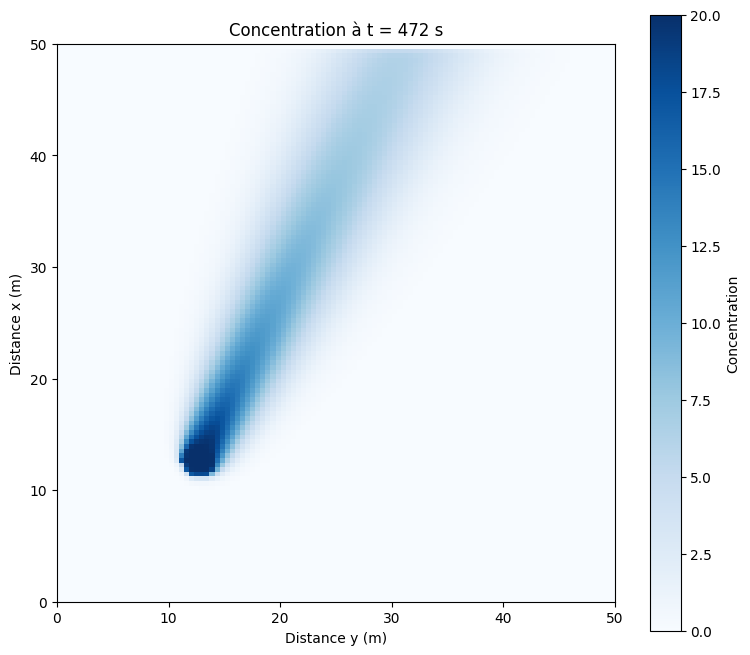

Progression : 94.6% (t = 472 s)


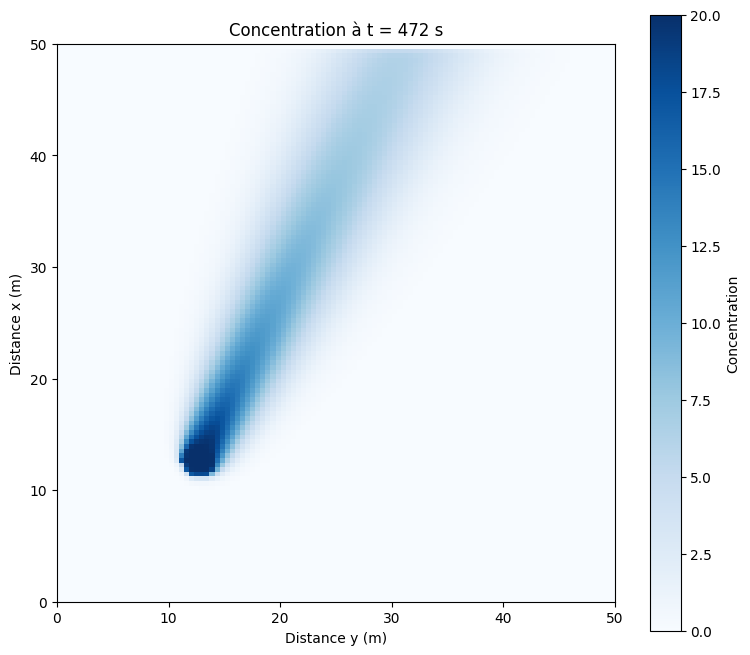

In [15]:
# ========================================
# SIMULATION COMPLÈTE
# ========================================

C = initial_solution()
Vx, Vy = initial_current()

dt = min(min(dx, dy)**2 / (4.1 * D), 
         0.1 * min(dx / np.max(np.abs(Vx)), dy / np.max(np.abs(Vy))))
nt = int(ttot / dt)

fig, ax = plt.subplots(figsize=(9, 8))
time = 0.0

for it in range(nt):
    time += dt
    
    update_source(C)
    update_diffusion(C, dt)
    update_advection(C, Vx, Vy, dt)
    update_reaction(C, dt)
    apply_bc(C)
    
    if it % nout == 0:
        plot_solution(C, time, fig, ax, first_call=(it==0))